# Introduction

In this tutorial we will forecast measles incidence using both the semi-mechanistic TSIR model and the LASSO machine learning model. We will employ the seminal England and Wales pre-vaccination bi-weekly measles dataset (a description of which can be found [here](https://doi.org/10.1371/journal.pcbi.1010251)).italicized text

First we install and load necessary R packages: the [`tsiR`](https://doi.org/10.1371/journal.pone.0185528) package, and the `glmnet` package.



In [23]:
library(tidyverse)

install.packages("tsiR")
library(tsiR)

install.packages("glmnet")
library(glmnet)

theme_set(theme_bw())
options(repr.plot.width = 10, repr.plot.height = 6, warn = -1)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Data

Next we read-in and inspect the measles dataset.

In [ ]:
# location of data in github repo
url_loc <- paste0("https://raw.githubusercontent.com/WyattGMadden/",
                  "intro_to_ml_for_id_emory/main/data/england_and_wales_measles/measles.csv")

# read in data
measles <- read_csv(url_loc)

In [14]:
head(measles)
#str(measles)
#summary(measles)

time,cases,births,pop,city,lat,lon
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1944.000,1,106.07441,118625.5,Birkenhead,53.388,-3.045
1944.038,0,104.28640,118457.8,Birkenhead,53.388,-3.045
1944.077,0,102.63108,118319.3,Birkenhead,53.388,-3.045
1944.115,0,101.47046,118233.3,Birkenhead,53.388,-3.045
1944.154,1,100.38986,118164.8,Birkenhead,53.388,-3.045
1944.192,1,99.05299,118096.4,Birkenhead,53.388,-3.045


[1] 40

This dataset contains measles incidence in forty cities from 1944-1965. Let us plot all the data prior to fitting models.

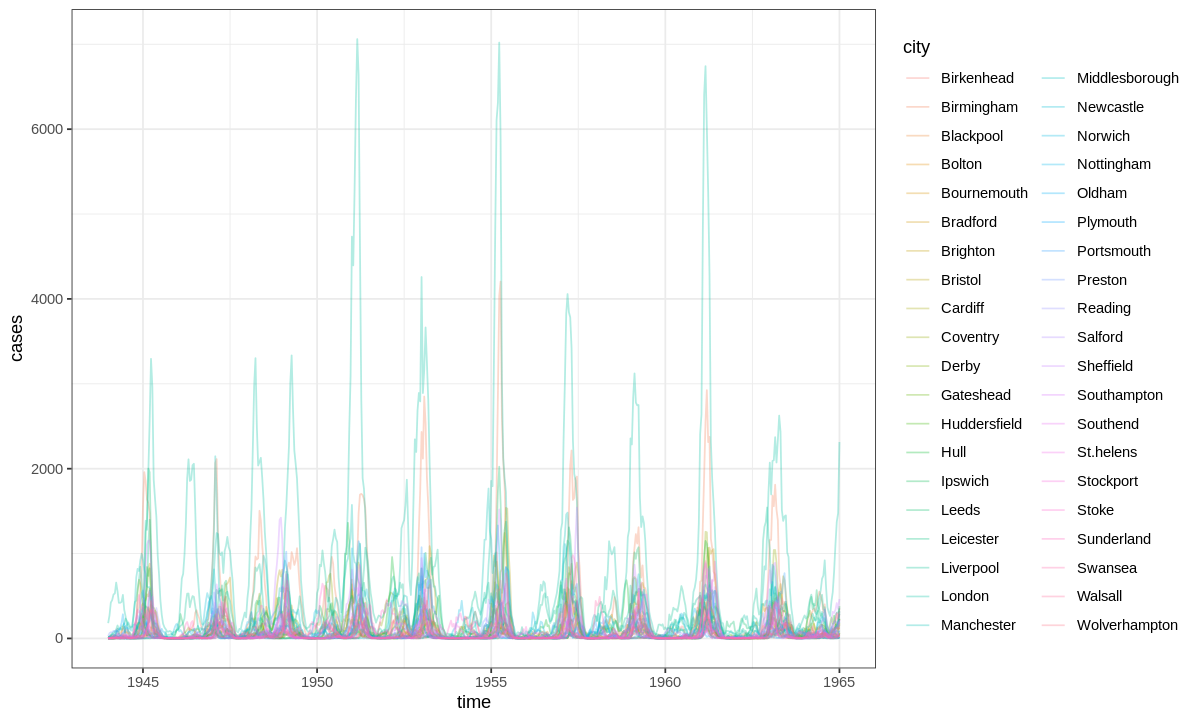

In [19]:
# plot all measles data over time
measles |>
    ggplot(aes(x = time, y = cases, color = city)) +
    geom_line(alpha = 0.3)

For now we will focus on just London measles incidence.

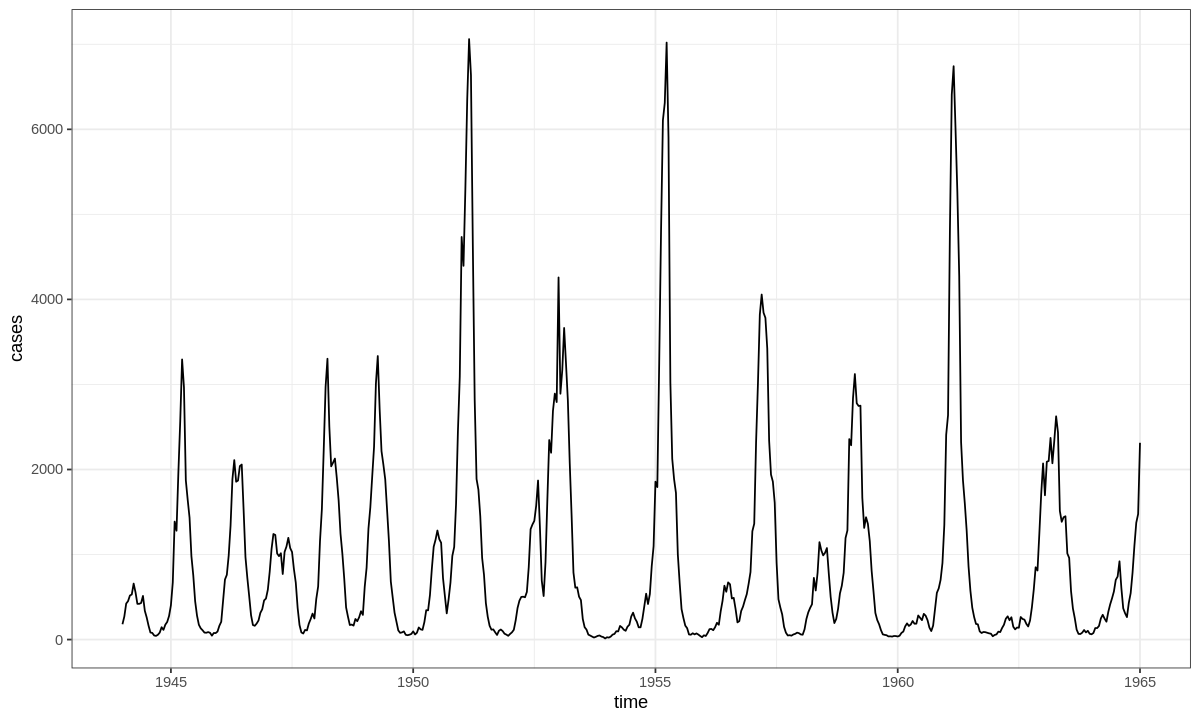

In [20]:
# make subset of just London measles data
london_measles <- measles |>
    filter(city == "London")

# plot London measles data
london_measles |>
    ggplot(aes(x = time, y = cases)) +
    geom_line()

# TSIR

Next we fit the TSIR model to the full london measles dataset. A paper accompanying the tsiR package can be found [here](https://doi.org/10.1371/journal.pone.0185528).

           alpha        mean beta         mean rho         mean sus 
        9.70e-01         1.10e-05         4.51e-01         1.19e+05 
prop. init. sus. prop. init. inf. 
        3.22e-02         5.85e-05 


Warning message in geom_line(data = dat$res, aes_string(x = "time", y = "cases", :
“Ignoring unknown aesthetics: fill”


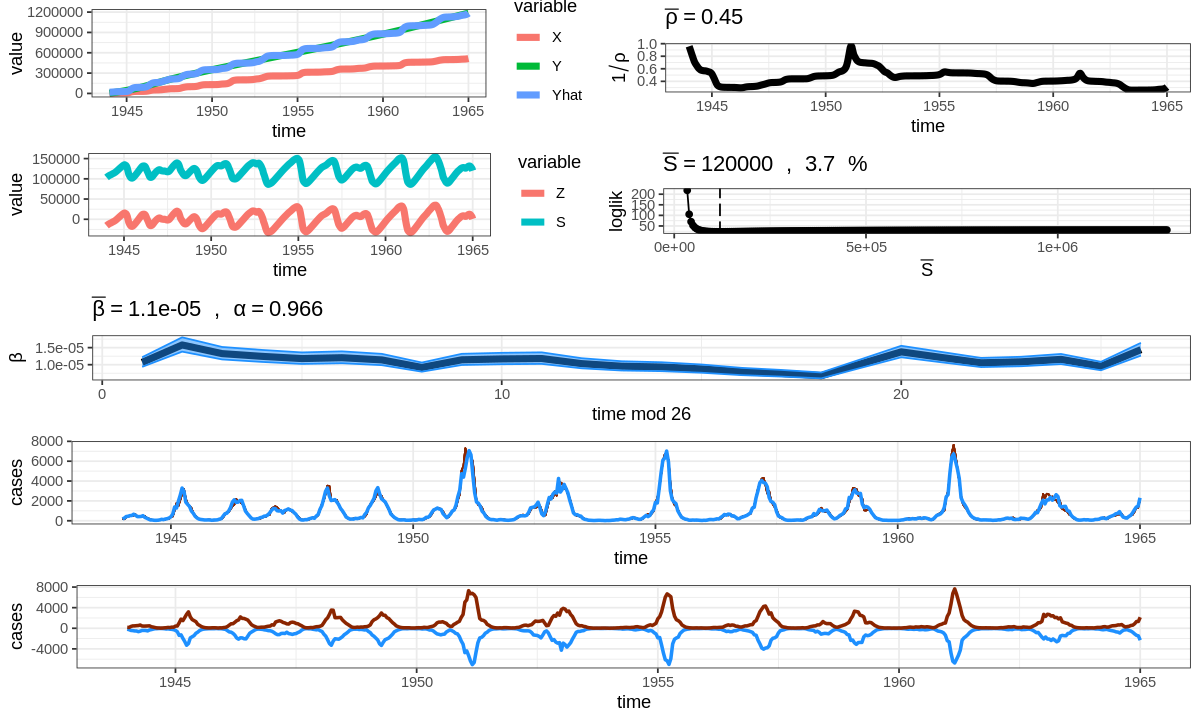

In [22]:
london_tsir <- runtsir(
    data = london_measles,
    IP = 2,
    xreg = 'cumcases',
    regtype = 'gaussian',
    alpha = NULL,
    sbar = NULL,
    family = 'gaussian',
    link = 'identity',
    method = 'deterministic',
    pred = 'step-ahead')

plotres(london_tsir)

## Exercises

1. Read the help file of the `runtsir` function (`?runtsir`) and explore different fitting options. Compare the summary plots.

2. Fit the tsir model in measles incidence for a different city.

In [ ]:
# conduct exercise here

Next we will generate one-step-ahead forecasts using the TSIR model. We will use a non-seasonal beta estimation to simplify forecasting. We again fit the TSIR model:

In [24]:
london_tsir_est <- runtsir(
    data = london_measles,
    IP = 2,
    xreg = 'cumcases',
    regtype = 'gaussian',
    alpha = NULL,
    sbar = NULL,
    family = 'gaussian',
    seasonality = "none",
    link = 'identity',
    method = 'deterministic',
    pred = 'step-ahead',
    nsim = 1)

           alpha        mean beta         mean rho         mean sus 
        9.70e-01         1.36e-05         4.51e-01         9.42e+04 
prop. init. sus. prop. init. inf. 
        2.44e-02         5.85e-05 


The TSIR updating equations are described as follows:

$S_{t+1} = B_{t + 1} - S_t - I_{t + 1}$

$E[I_{t + 1}] = \beta S_t I^{\alpha}_t$

Where $S$ are the reconstructed susceptibles provided by the TSIR model, $B$ are the births, $I$ is the true case number ($I$ x reporting rate = incidence), and $\beta$ and $\alpha$ are estimated parameters.

We first find the values of interest from the model output:

In [25]:
# beta
beta_est <- unique(london_tsir_est$beta)

# alpha
alpha_est <- london_tsir_est$alpha

# reporting rate
rho_est <- london_tsir_est$rho

# reconstructed susceptibles
S_est <- london_tsir_est$simS[, "mean"]

# estimated incidence
incidence_est <- london_tsir_est$res$mean

# estimated I
I_est <- incidence_est * rho_est

Next we create empty vectors to store forecasts and intermediate values.

In [26]:
S_one_step_ahead <- rep(NA, nrow(london_measles))
I_one_step_ahead <- rep(NA, nrow(london_measles))
cases_one_step_ahead <- rep(NA, nrow(london_measles))

We also create a one-year-lagged births vector to prevent using future data in our forecasts while maintaining aligned birth seasonality.

In [28]:
# births from one year ago
births_for_pred <- lag(london_measles$births, 26)

We are now ready to calculate one-step-ahead forecasts.

In [29]:
# iteratively calculate forecasts
for (i in 2:nrow(london_measles)) {
    I_one_step_ahead[i] <- beta_est * S_est[i - 1] * (I_est[i - 1])^alpha_est
    cases_one_step_ahead[i] <- I_one_step_ahead[i] / rho_est[i - 1]
    S_one_step_ahead[i] <- births_for_pred[i] + S_est[i - 1] - I_one_step_ahead[i]
}

Let us now visually compare the forecasts to the true incidence values.

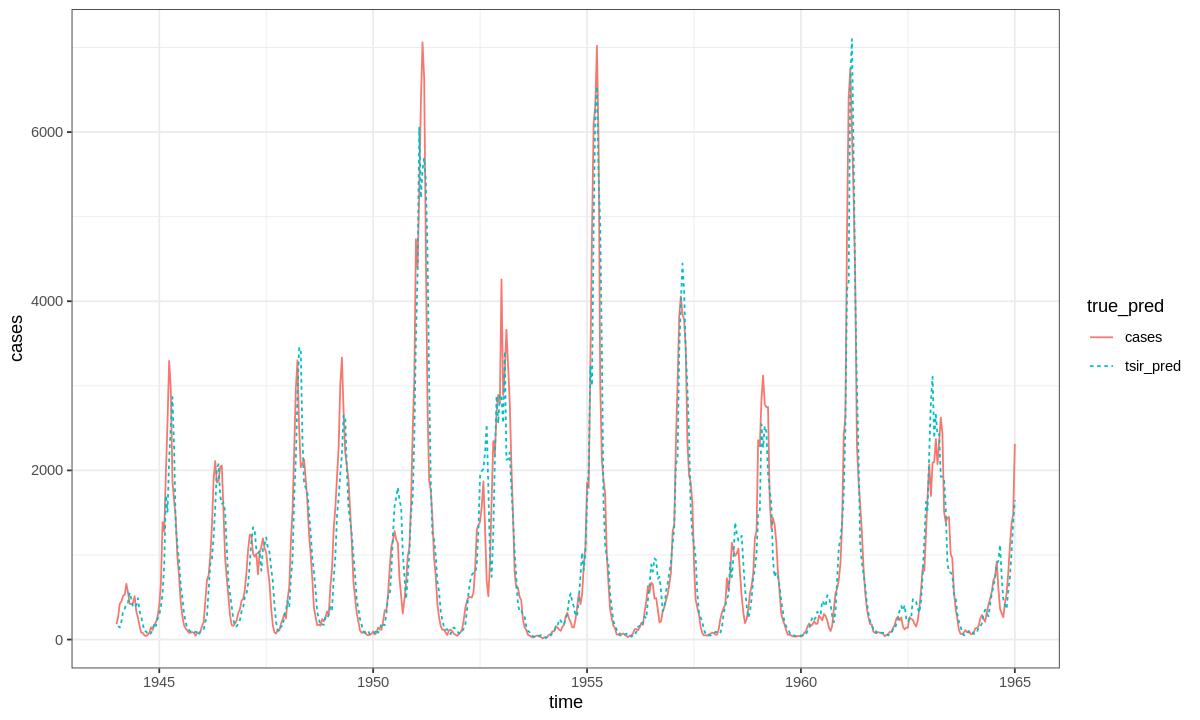

In [30]:
london_tsir_pred <- london_measles
london_tsir_pred$tsir_pred <- cases_one_step_ahead

london_tsir_pred |>
    pivot_longer(c("cases", "tsir_pred"), names_to = "true_pred", values_to = "cases") |>
    ggplot(aes(x = time, y = cases, color = true_pred, linetype = true_pred)) +
    geom_line()


## Exercises

1. Try forecast two (or more) steps ahead.

2. Attempt to forecast on a city other than London.

3. How might you account for seasonal beta terms in the forecast?

# LASSO

Next we fit the LASSO machine learning model to the same London measles data. The LASSO is a flexible regression model that is often more performant than mechanistic/semi-mechanistic models. Rather then making iterative step-ahead predictions, we instead include lagged measles incidence values as features. We fit the regression model on a training data set (the first 70% of the data in this case), and assess performance on the remainder of the data.

The model is written as follows:

$log(E(I_{i, t + k})) = \eta + \sum\limits^{T_{lag}}_{J = 1} \Psi_J log(I_{i, t - J + 1}) + \gamma log(\bar{B}_{i, (t - T_{lag}):t} + 1)$

Here we are regressing lagged log-incidence (with lags ranging from k steps prior to $T_{lag}$ steps prior) and the mean births over the lags, on the current-step log-incidence. Further explanation can be found [here](https://doi.org/10.1371/journal.pcbi.1010251).

We start by setting $T_{lag}$ to 130 creating the lag-incidence features and the mean birth feature. As in the TSIR section, we will forecast one-step-ahead.

In [31]:
# initialize data and T_lag
lasso_data <- london_measles
T_lag <- 130

lasso_data$log1_cases <- log(lasso_data$cases + 1)

# get case lags
for (i in 1:T_lag) {
    lasso_data[, paste0("log1_cases_lag", i)] <- lag(lasso_data$log1_cases, i)
}

# get mean births
lasso_data$log1_mean_births_lag <- rep(NA, nrow(lasso_data))
for (i in (T_lag + 1):nrow(lasso_data)) {
    lasso_data$log1_mean_births_lag[i] <- log(mean(lasso_data$births[(i - T_lag):(i - 1)]) + 1)
}

# remove first 130 data rows with NA lag incidence values
lasso_data_full <- lasso_data[!is.na(lasso_data$log1_mean_births_lag), ]


Next we divide our dataset into training and testing, and create the respective Y and X matrices for use in the LASSO fitting function.

In [33]:
train_set_proportion <- 0.7
train_set_size <- round(nrow(lasso_data_full) * train_set_proportion)
lasso_data_train <- lasso_data_full[1:train_set_size, ]
lasso_data_test <- lasso_data_full[(train_set_size + 1):nrow(lasso_data_full), ]


Y_train <- lasso_data_train$cases

# get column names for all features (incidence lags and mean-births)
X_col_names <- c(grep("log1_cases_lag", names(lasso_data), value = T),
                 "log1_mean_births_lag")
X_train <- as.matrix(lasso_data_train[, X_col_names])


Lasso uses a penalized L1 loss term in addition to the standard MSE loss: $\lambda \sum\limits^p_{k=1} |\theta_k|$, where $\lambda$ is a hyperparameter.
Here we select $\lambda$ using cross validation:

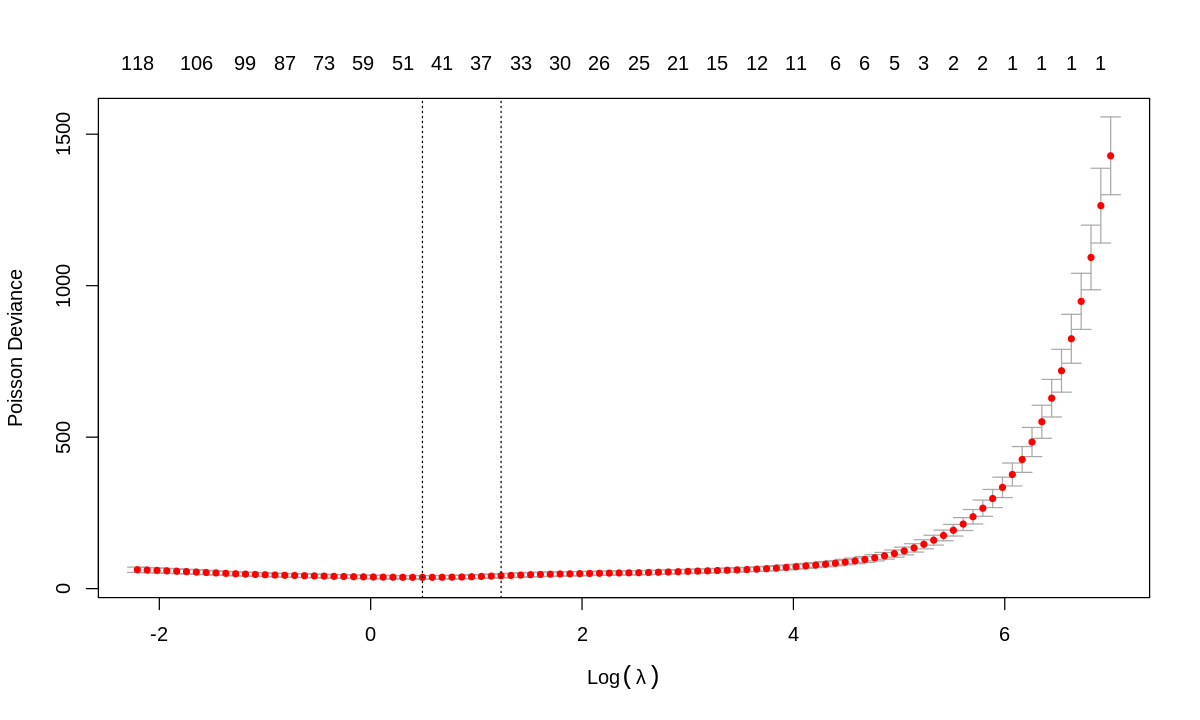

In [34]:
# estimate lambda
cv.lasso.oneahead <- cv.glmnet(
    X_train,
    Y_train,
    alpha = 1,
    lower.limits = -Inf,
    family = "poisson",
    intercept = T)

plot(cv.lasso.oneahead)

Now we are ready to fit the LASSO on the training dataset.

In [37]:
model.oneahead <- glmnet(
    X_train,
    Y_train,
    alpha = 1,
    family = "poisson",
    lambda = cv.lasso.oneahead$lambda.1se)

We can make predictions on the training set as follows:

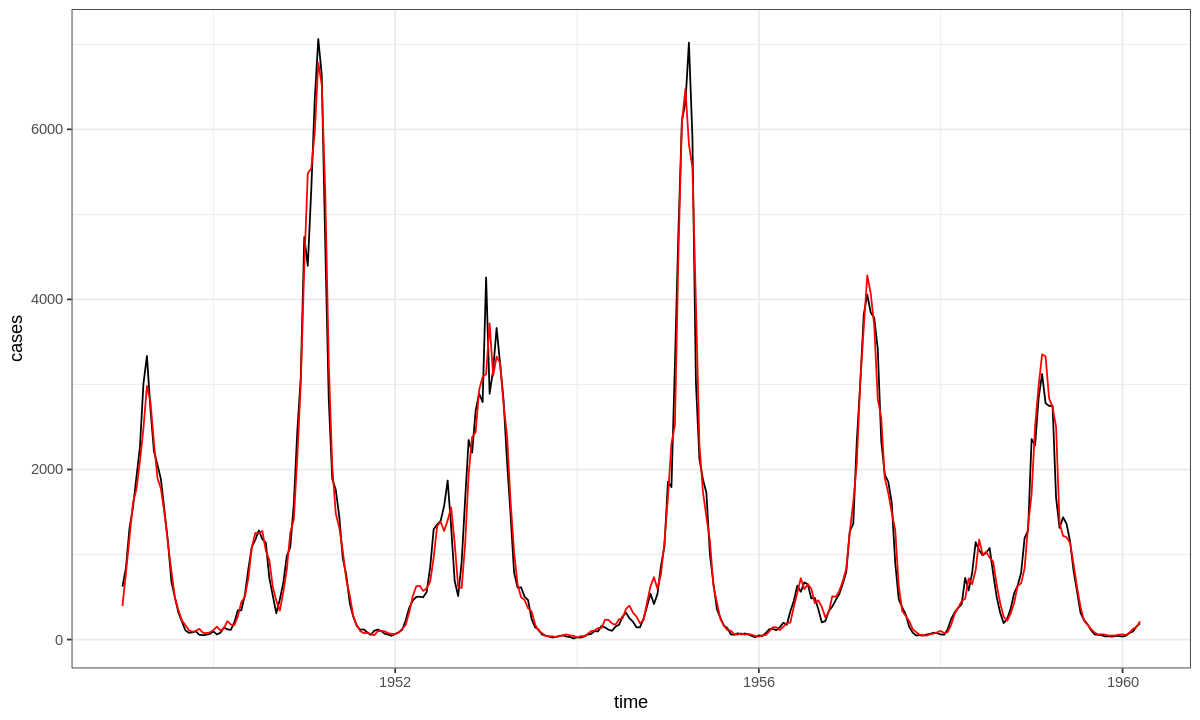

In [38]:
train_pred <- predict(
    model.oneahead,
    newx = X_train,
    type = "response"
    )

lasso_data_train$pred <- train_pred

lasso_data_train |>
    ggplot(aes(x = time)) +
    geom_line(aes(y = cases)) +
    geom_line(aes(y = pred), colour = "red")

LASSO appears to forecast one-step ahead very accurately on the training dataset. Is performance similarly high on the test dataset?

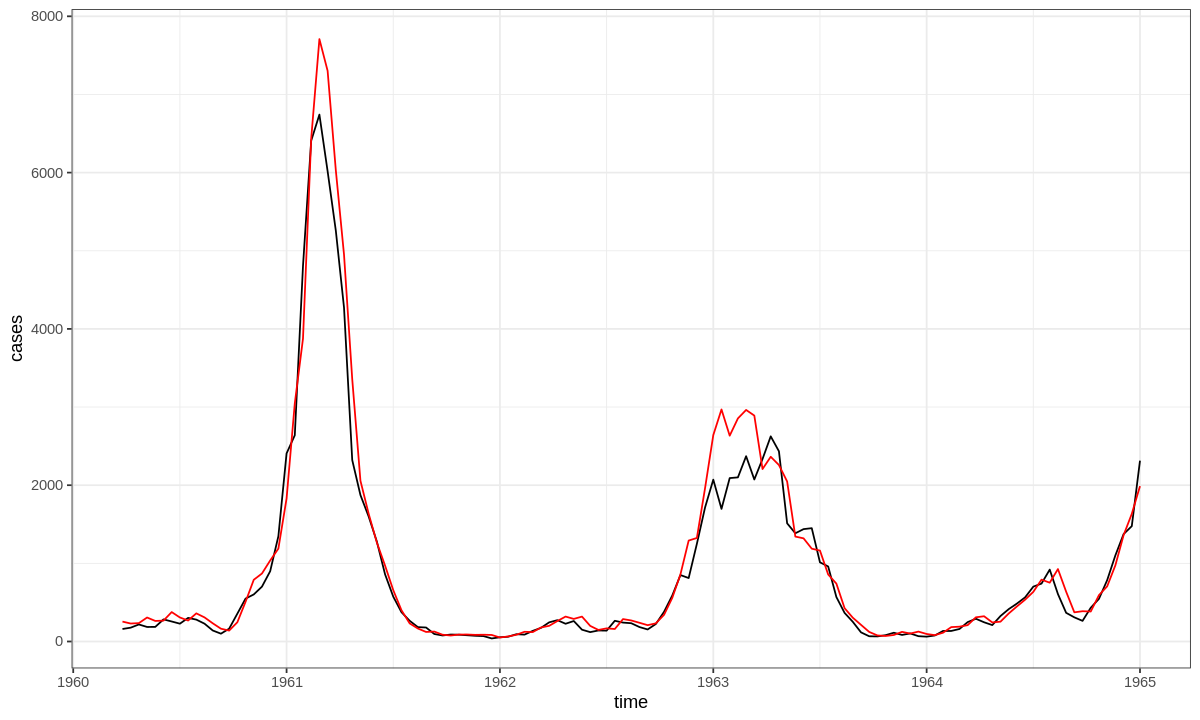

In [39]:
X_test <- as.matrix(lasso_data_test[, X_col_names])

test_pred <- predict(
    model.oneahead,
    newx = X_test,
    type = "response"
    )

lasso_data_test$lasso_pred <- test_pred

lasso_data_test |>
    ggplot(aes(x = time)) +
    geom_line(aes(y = cases)) +
    geom_line(aes(y = lasso_pred), colour = "red")

Finally, let us compare TSIR predictions with LASSO predictions.

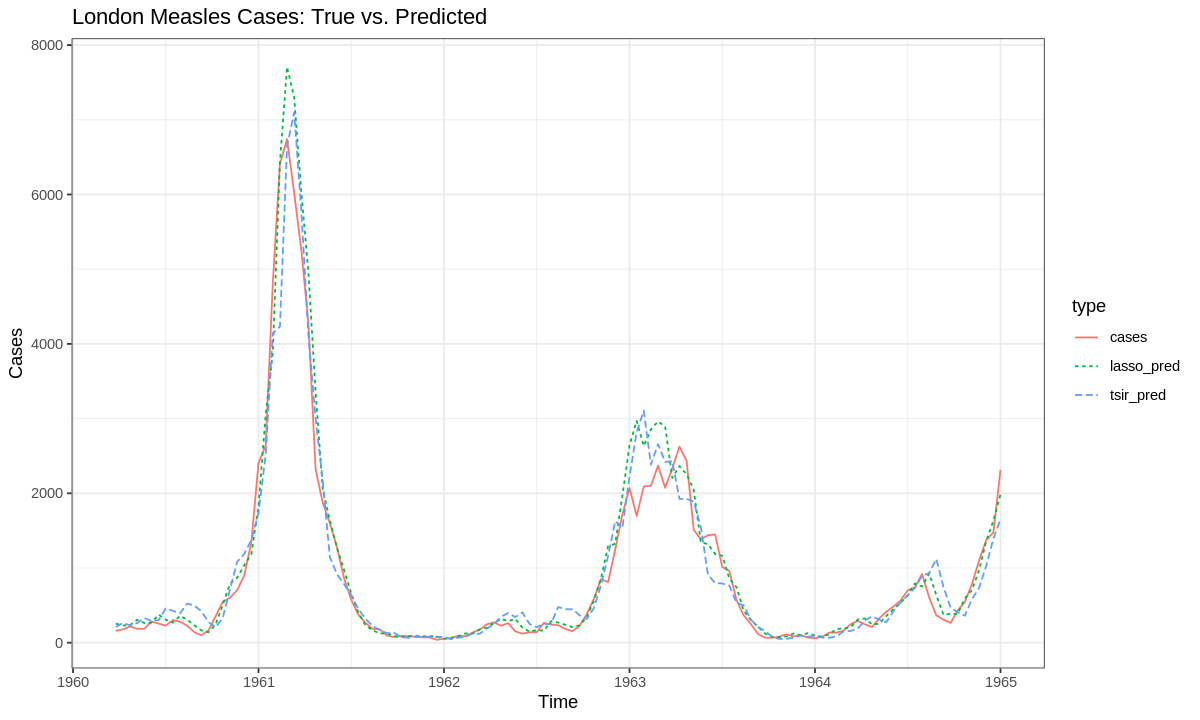

In [48]:
tsir_pred <- london_tsir_pred[london_tsir_pred$time %in% lasso_data_test$time, ]
lasso_data_test$tsir_pred <- tsir_pred$tsir_pred

lasso_data_test |>
    pivot_longer(c("cases", "tsir_pred", "lasso_pred"),
                 names_to = "type",
                 values_to = "value") |>
    ggplot(aes(x = time, y = value, color = type, linetype = type)) +
    geom_line() +
    labs(title = "London Measles Cases: True vs. Predicted",
         x = "Time",
         y = "Cases")

In [51]:
tsir_mse <- mean((lasso_data_test$cases - lasso_data_test$tsir_pred)^2)
lasso_mse <- mean((lasso_data_test$cases - lasso_data_test$lasso_pred)^2)

print(paste0("TSIR MSE: ", round(tsir_mse, 2)))
print(paste0("LASSO MSE: ", round(lasso_mse, 2)))

[1] "TSIR MSE: 125248.97"
[1] "LASSO MSE: 92179.94"


# Exercises

1. Mean Absolute Error (MAE) may be a more appropriate metric due to large positive incidence values. Calculate MAE for the TSIR and LASSO test predictions.

2. Experiment with different $T_{lag}$ values. Is the LASSO still better than TSIR for small $T_{lag}$ values.

3. Fit the LASSO model on a differenct city and/or for different step-ahead forecasts.

